In [1]:
import torch
import torch.nn as nn
import torch.optim as optim
from torch.utils.data import DataLoader, SubsetRandomSampler, random_split
from torchvision import datasets, transforms
from sklearn.model_selection import KFold
from sklearn.metrics import precision_recall_fscore_support, confusion_matrix, roc_curve, auc
from sklearn.preprocessing import label_binarize
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns

In [11]:
def load_and_split_data(data_dir, test_split=0.1, batch_size=32):
    transform = transforms.Compose([
        transforms.ToTensor(),
    ])

    full_dataset = datasets.ImageFolder(root=data_dir, transform=transform)

    # Split into train+val and test
    num_test = int(len(full_dataset) * test_split)
    num_train_val = len(full_dataset) - num_test
    train_val_dataset, test_dataset = random_split(full_dataset, [num_train_val, num_test])

    test_loader = DataLoader(test_dataset, batch_size=batch_size, shuffle=False)

    num_classes = len(full_dataset.classes)

    print(f"Número de clases: {num_classes}")
    print(f"Tamaño del conjunto de entrenamiento + validación: {num_train_val}")
    print(f"Tamaño del conjunto de prueba: {num_test}")

    return train_val_dataset, test_loader, num_classes

def create_model(num_classes):
    return nn.Sequential(
        nn.Conv2d(3, 32, kernel_size=3, padding=1),
        nn.ReLU(),
        nn.MaxPool2d(2, 2),
        nn.Conv2d(32, 64, kernel_size=3, padding=1),
        nn.ReLU(),
        nn.MaxPool2d(2, 2),
        nn.Conv2d(64, 128, kernel_size=3, padding=1),
        nn.ReLU(),
        nn.MaxPool2d(2, 2),
        nn.AdaptiveAvgPool2d((7, 7)),
        nn.Flatten(),
        nn.Linear(128 * 7 * 7, 256),
        nn.ReLU(),
        nn.Dropout(0.5),
        nn.Linear(256, num_classes)
    )

def train_model(model, train_loader, val_loader, epochs=20, lr=0.001):
    device = torch.device("cuda" if torch.cuda.is_available() else "cpu")
    model.to(device)

    criterion = nn.CrossEntropyLoss()
    optimizer = optim.AdamW(model.parameters(), lr=lr)

    train_losses, val_losses = [], []
    train_metrics, val_metrics = [], []

    for epoch in range(epochs):
        model.train()
        running_loss = 0.0
        train_preds, train_labels = [], []

        for inputs, labels in train_loader:
            inputs, labels = inputs.to(device), labels.to(device)

            optimizer.zero_grad()
            outputs = model(inputs)
            loss = criterion(outputs, labels)
            loss.backward()
            optimizer.step()

            running_loss += loss.item()
            _, preds = torch.max(outputs, 1)
            train_preds.extend(preds.cpu().numpy())
            train_labels.extend(labels.cpu().numpy())

        train_loss = running_loss / len(train_loader)
        train_losses.append(train_loss)

        train_precision, train_recall, train_f1, _ = precision_recall_fscore_support(train_labels, train_preds, average='weighted')
        train_metrics.append((train_precision, train_recall, train_f1))

        model.eval()
        val_loss = 0.0
        val_preds, val_labels = [], []
        with torch.no_grad():
            for inputs, labels in val_loader:
                inputs, labels = inputs.to(device), labels.to(device)
                outputs = model(inputs)
                loss = criterion(outputs, labels)
                val_loss += loss.item()

                _, preds = torch.max(outputs, 1)
                val_preds.extend(preds.cpu().numpy())
                val_labels.extend(labels.cpu().numpy())

        val_loss /= len(val_loader)
        val_losses.append(val_loss)

        val_precision, val_recall, val_f1, _ = precision_recall_fscore_support(val_labels, val_preds, average='weighted')
        val_metrics.append((val_precision, val_recall, val_f1))

        print(f"Época {epoch+1}/{epochs}")
        print(f"Train Loss: {train_loss:.4f}, Val Loss: {val_loss:.4f}")
        print(f"Train Metrics: Precision={train_precision:.4f}, Recall={train_recall:.4f}, F1={train_f1:.4f}")
        print(f"Val Metrics: Precision={val_precision:.4f}, Recall={val_recall:.4f}, F1={val_f1:.4f}")

    return train_losses, val_losses, train_metrics, val_metrics

def cross_validate(dataset, num_classes, k_folds=5, epochs=20, lr=0.001):
    kfold = KFold(n_splits=k_folds, shuffle=True)

    fold_results = []

    for fold, (train_ids, val_ids) in enumerate(kfold.split(dataset)):
        print(f'FOLD {fold+1}')
        print('--------------------------------')

        train_subsampler = SubsetRandomSampler(train_ids)
        val_subsampler = SubsetRandomSampler(val_ids)

        trainloader = DataLoader(dataset, batch_size=32, sampler=train_subsampler)
        valloader = DataLoader(dataset, batch_size=32, sampler=val_subsampler)

        model = create_model(num_classes)

        results = train_model(model, trainloader, valloader, epochs, lr)
        fold_results.append(results)

        print('--------------------------------')

    return fold_results

def evaluate_model(model, testloader, num_classes):
    device = torch.device("cuda" if torch.cuda.is_available() else "cpu")
    model.to(device)

    model.eval()
    all_preds = []
    all_labels = []
    all_probs = []

    with torch.no_grad():
        for inputs, labels in testloader:
            inputs, labels = inputs.to(device), labels.to(device)
            outputs = model(inputs)
            probs = torch.softmax(outputs, dim=1)
            _, preds = torch.max(outputs, 1)
            all_preds.extend(preds.cpu().numpy())
            all_labels.extend(labels.cpu().numpy())
            all_probs.extend(probs.cpu().numpy())

    all_preds = np.array(all_preds)
    all_labels = np.array(all_labels)
    all_probs = np.array(all_probs)

    precision, recall, f1, _ = precision_recall_fscore_support(all_labels, all_preds, average='weighted')
    cm = confusion_matrix(all_labels, all_preds)

    print("Matriz de confusión:\n", cm)
    print(f'Precision: {precision:.4f}')
    print(f'Recall: {recall:.4f}')
    print(f'F1-score: {f1:.4f}')

    return all_labels, all_preds, all_probs, cm, precision, recall, f1

def plot_training_history(train_losses, val_losses, train_metrics, val_metrics):
    plt.figure(figsize=(20, 15))

    plt.subplot(2, 2, 1)
    plt.plot(train_losses, label='Entrenamiento')
    plt.plot(val_losses, label='Validación')
    plt.title('Pérdida por época')
    plt.xlabel('Época')
    plt.ylabel('Pérdida')
    plt.legend()

    plt.subplot(2, 2, 2)
    plt.plot([m[0] for m in train_metrics], label='Entrenamiento')
    plt.plot([m[0] for m in val_metrics], label='Validación')
    plt.title('Precisión por época')
    plt.xlabel('Época')
    plt.ylabel('Precisión')
    plt.legend()

    plt.subplot(2, 2, 3)
    plt.plot([m[1] for m in train_metrics], label='Entrenamiento')
    plt.plot([m[1] for m in val_metrics], label='Validación')
    plt.title('Recall por época')
    plt.xlabel('Época')
    plt.ylabel('Recall')
    plt.legend()

    plt.subplot(2, 2, 4)
    plt.plot([m[2] for m in train_metrics], label='Entrenamiento')
    plt.plot([m[2] for m in val_metrics], label='Validación')
    plt.title('F1-score por época')
    plt.xlabel('Época')
    plt.ylabel('F1-score')
    plt.legend()

    plt.tight_layout()
    plt.show()

def plot_roc_curve(all_labels, all_probs, num_classes):
    all_labels_bin = label_binarize(all_labels, classes=range(num_classes))

    fpr = dict()
    tpr = dict()
    roc_auc = dict()
    for i in range(num_classes):
        fpr[i], tpr[i], _ = roc_curve(all_labels_bin[:, i], all_probs[:, i])
        roc_auc[i] = auc(fpr[i], tpr[i])

    fpr["micro"], tpr["micro"], _ = roc_curve(all_labels_bin.ravel(), all_probs.ravel())
    roc_auc["micro"] = auc(fpr["micro"], tpr["micro"])

    plt.figure(figsize=(10, 8))
    plt.plot(fpr["micro"], tpr["micro"],
             label='micro-average ROC curve (area = {0:0.2f})'
                   ''.format(roc_auc["micro"]),
             color='deeppink', linestyle=':', linewidth=4)

    for i in range(num_classes):
        plt.plot(fpr[i], tpr[i],
                 label='ROC curve of class {0} (area = {1:0.2f})'
                       ''.format(i, roc_auc[i]))

    plt.plot([0, 1], [0, 1], 'k--')
    plt.xlim([0.0, 1.0])
    plt.ylim([0.0, 1.05])
    plt.xlabel('False Positive Rate')
    plt.ylabel('True Positive Rate')
    plt.title('Receiver Operating Characteristic (ROC) Curve')
    plt.legend(loc="lower right")
    plt.show()

def plot_confusion_matrix(cm):
    plt.figure(figsize=(10, 8))
    sns.heatmap(cm, annot=True, fmt='d', cmap='Blues')
    plt.xlabel('Predicción')
    plt.ylabel('Real')
    plt.title('Matriz de Confusión')
    plt.show()



In [3]:
!unrar x /content/preprocessed_potato_leaf /content/finaldata/

Se han truncado las últimas 5000 líneas del flujo de salida.
Extracting  /content/finaldata/preprocessed_potato_leaf/Enfermedades virales/imagen_0205.jpg      48%  OK 
Extracting  /content/finaldata/preprocessed_potato_leaf/Enfermedades virales/imagen_0206.jpg      48%  OK 
Extracting  /content/finaldata/preprocessed_potato_leaf/Enfermedades virales/imagen_0207.jpg      48%  OK 
Extracting  /content/finaldata/preprocessed_potato_leaf/Enfermedades virales/imagen_0208.jpg      48%  OK 
Extracting  /content/finaldata/preprocessed_potato_leaf/Enfermedades virales/imagen_0209.jpg      48%  OK 
Extracting  /content/finaldata/preprocessed_potato_leaf/Enfermedades virales/imagen_0210.jpg      48%  OK 
Extracting  /content/finaldata/preprocessed_potato_leaf/Enfermedades virales/imagen_0211.jpg      48%  OK 
Extracting  /content/finaldata/preprocessed_potato_leaf/Enfermedades virales/imagen_0212.jpg      48%  OK 
Extracting 

In [10]:
!ls /content/finaldata/preprocessed_potato_leaf

'Daños por nematodos'	    'Enfermedades fúngicas'  'Tizón tardío (Phytophthora)'
'Daños por plagas'	    'Enfermedades virales'   'Tizón temprano'
'Enfermedades bacterianas'   Salud


In [12]:
#Cargar y dividir los datos
data_dir = "/content/finaldata/preprocessed_potato_leaf"
train_val_dataset, test_loader, num_classes = load_and_split_data(data_dir)

Número de clases: 8
Tamaño del conjunto de entrenamiento + validación: 9360
Tamaño del conjunto de prueba: 1040


In [13]:
# Realizar validación cruzada
k_folds = 5
epochs = 20
lr = 0.001
fold_results = cross_validate(train_val_dataset, num_classes, k_folds, epochs, lr)


FOLD 1
--------------------------------
Época 1/20
Train Loss: 1.3043, Val Loss: 1.0100
Train Metrics: Precision=0.4756, Recall=0.4913, F1=0.4800
Val Metrics: Precision=0.6359, Recall=0.6175, F1=0.5954
Época 2/20
Train Loss: 0.9325, Val Loss: 0.7730
Train Metrics: Precision=0.6310, Recall=0.6343, F1=0.6292
Val Metrics: Precision=0.7043, Recall=0.6822, F1=0.6646
Época 3/20
Train Loss: 0.8222, Val Loss: 0.7074
Train Metrics: Precision=0.6781, Recall=0.6827, F1=0.6772
Val Metrics: Precision=0.7129, Recall=0.7212, F1=0.7151
Época 4/20
Train Loss: 0.7478, Val Loss: 0.7468
Train Metrics: Precision=0.7176, Recall=0.7169, F1=0.7146
Val Metrics: Precision=0.7417, Recall=0.7196, F1=0.7040
Época 5/20
Train Loss: 0.6871, Val Loss: 0.6687
Train Metrics: Precision=0.7391, Recall=0.7388, F1=0.7364
Val Metrics: Precision=0.7548, Recall=0.7500, F1=0.7445
Época 6/20
Train Loss: 0.6462, Val Loss: 0.6672
Train Metrics: Precision=0.7591, Recall=0.7575, F1=0.7566
Val Metrics: Precision=0.7627, Recall=0.7521

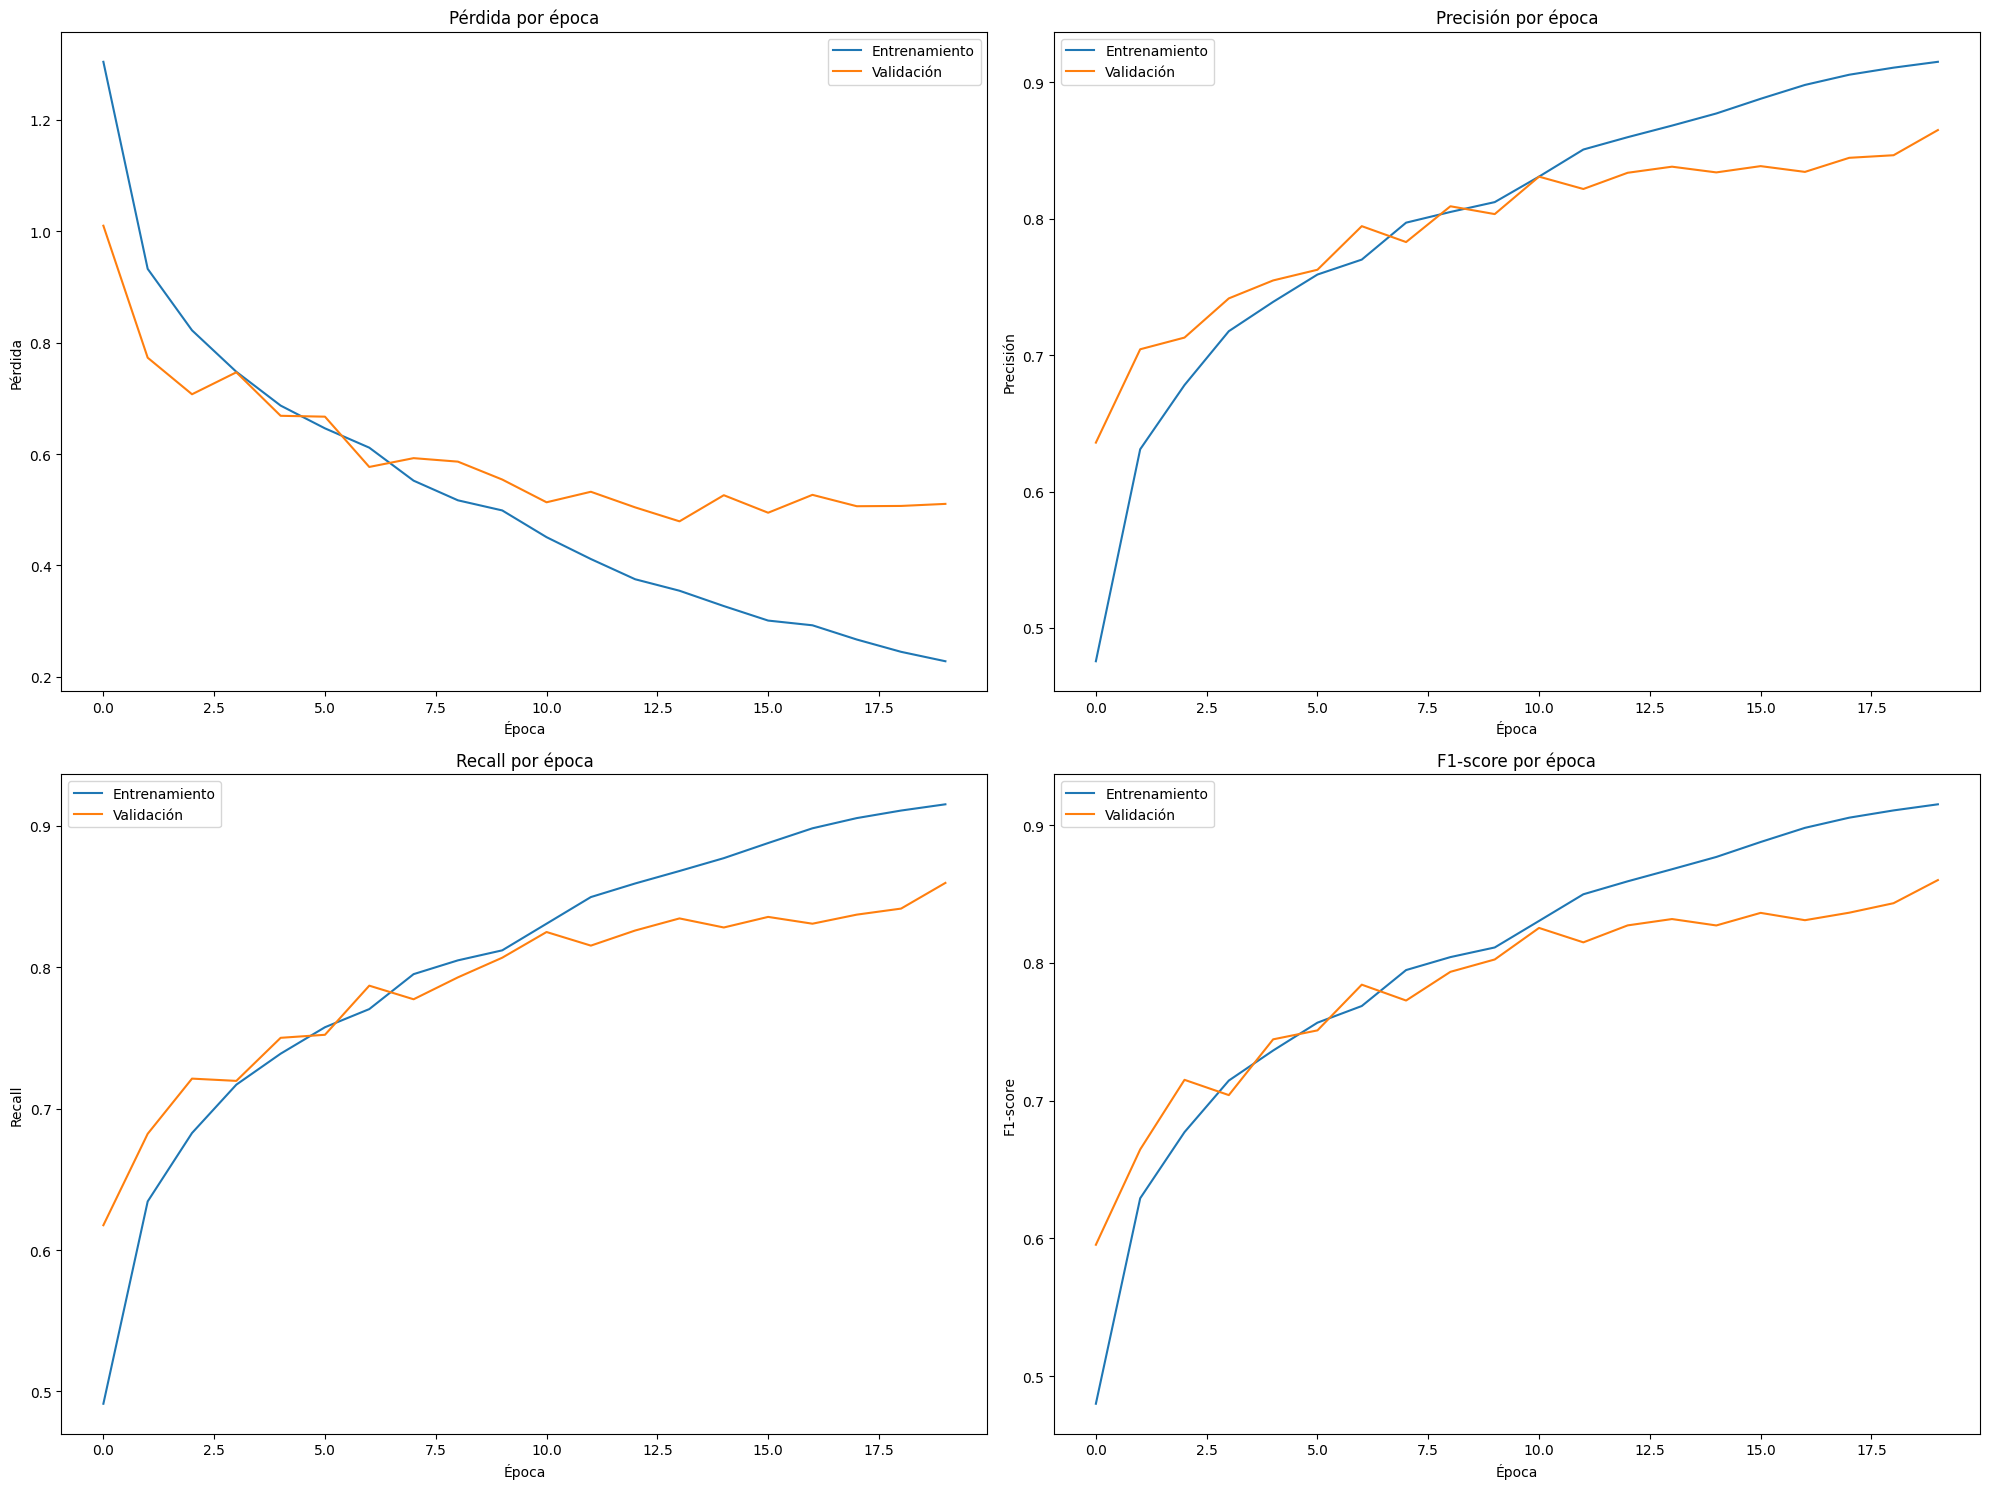

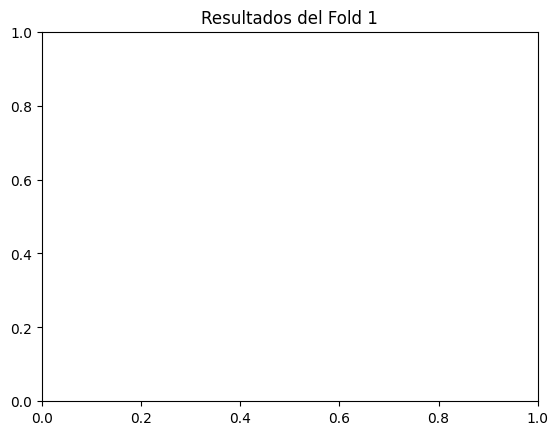

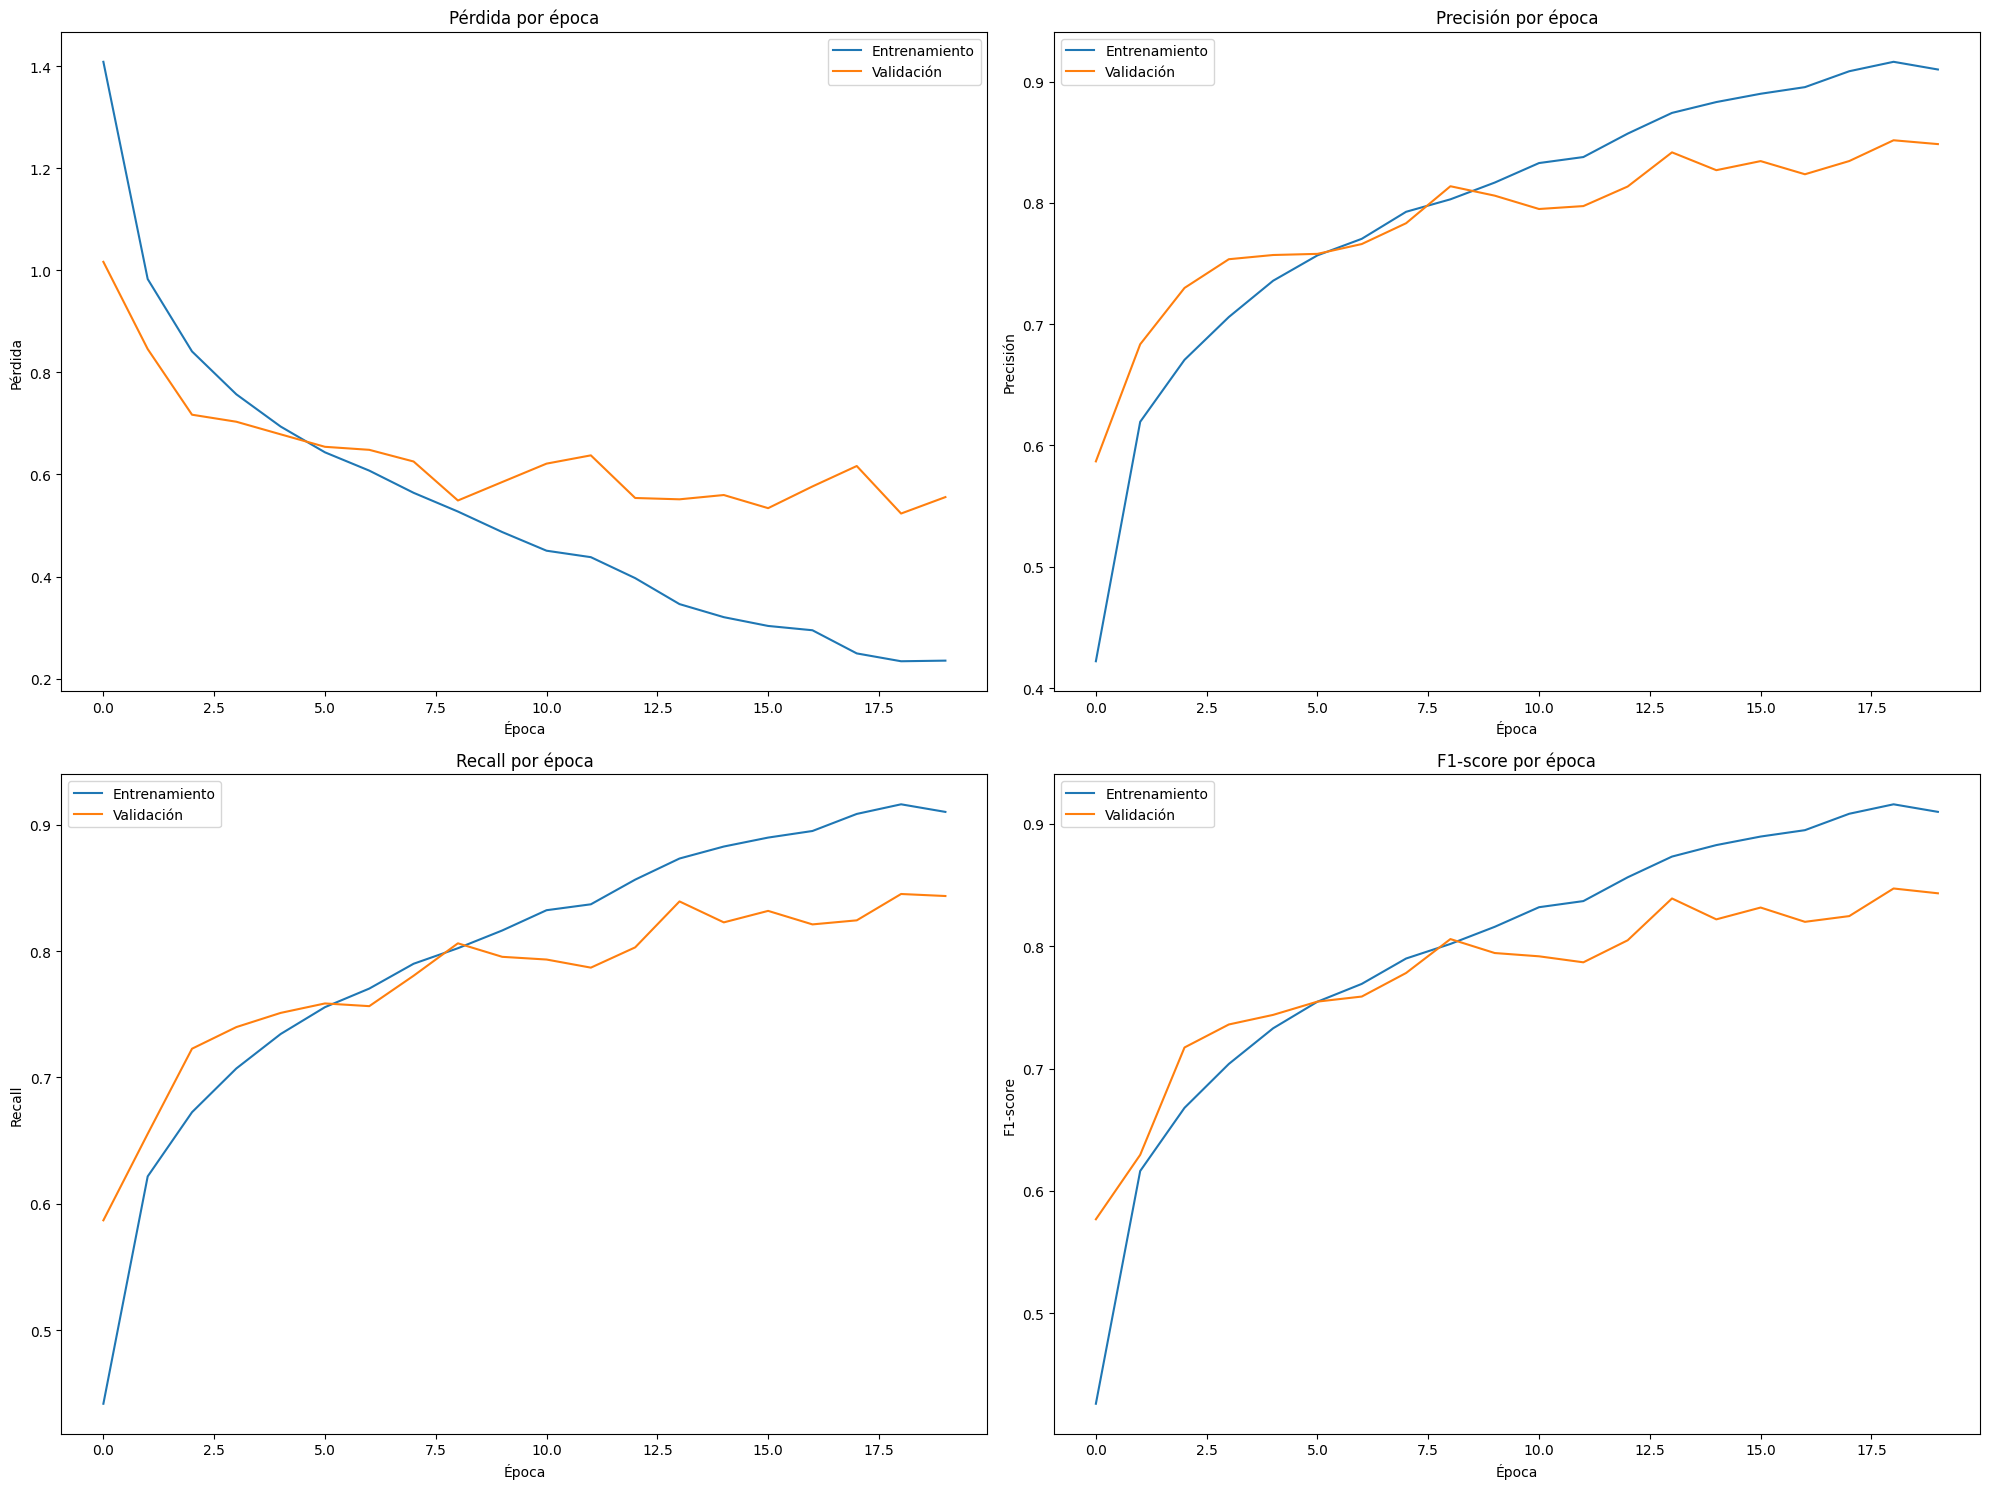

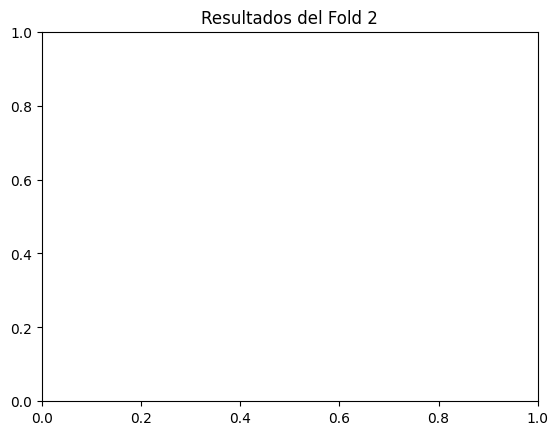

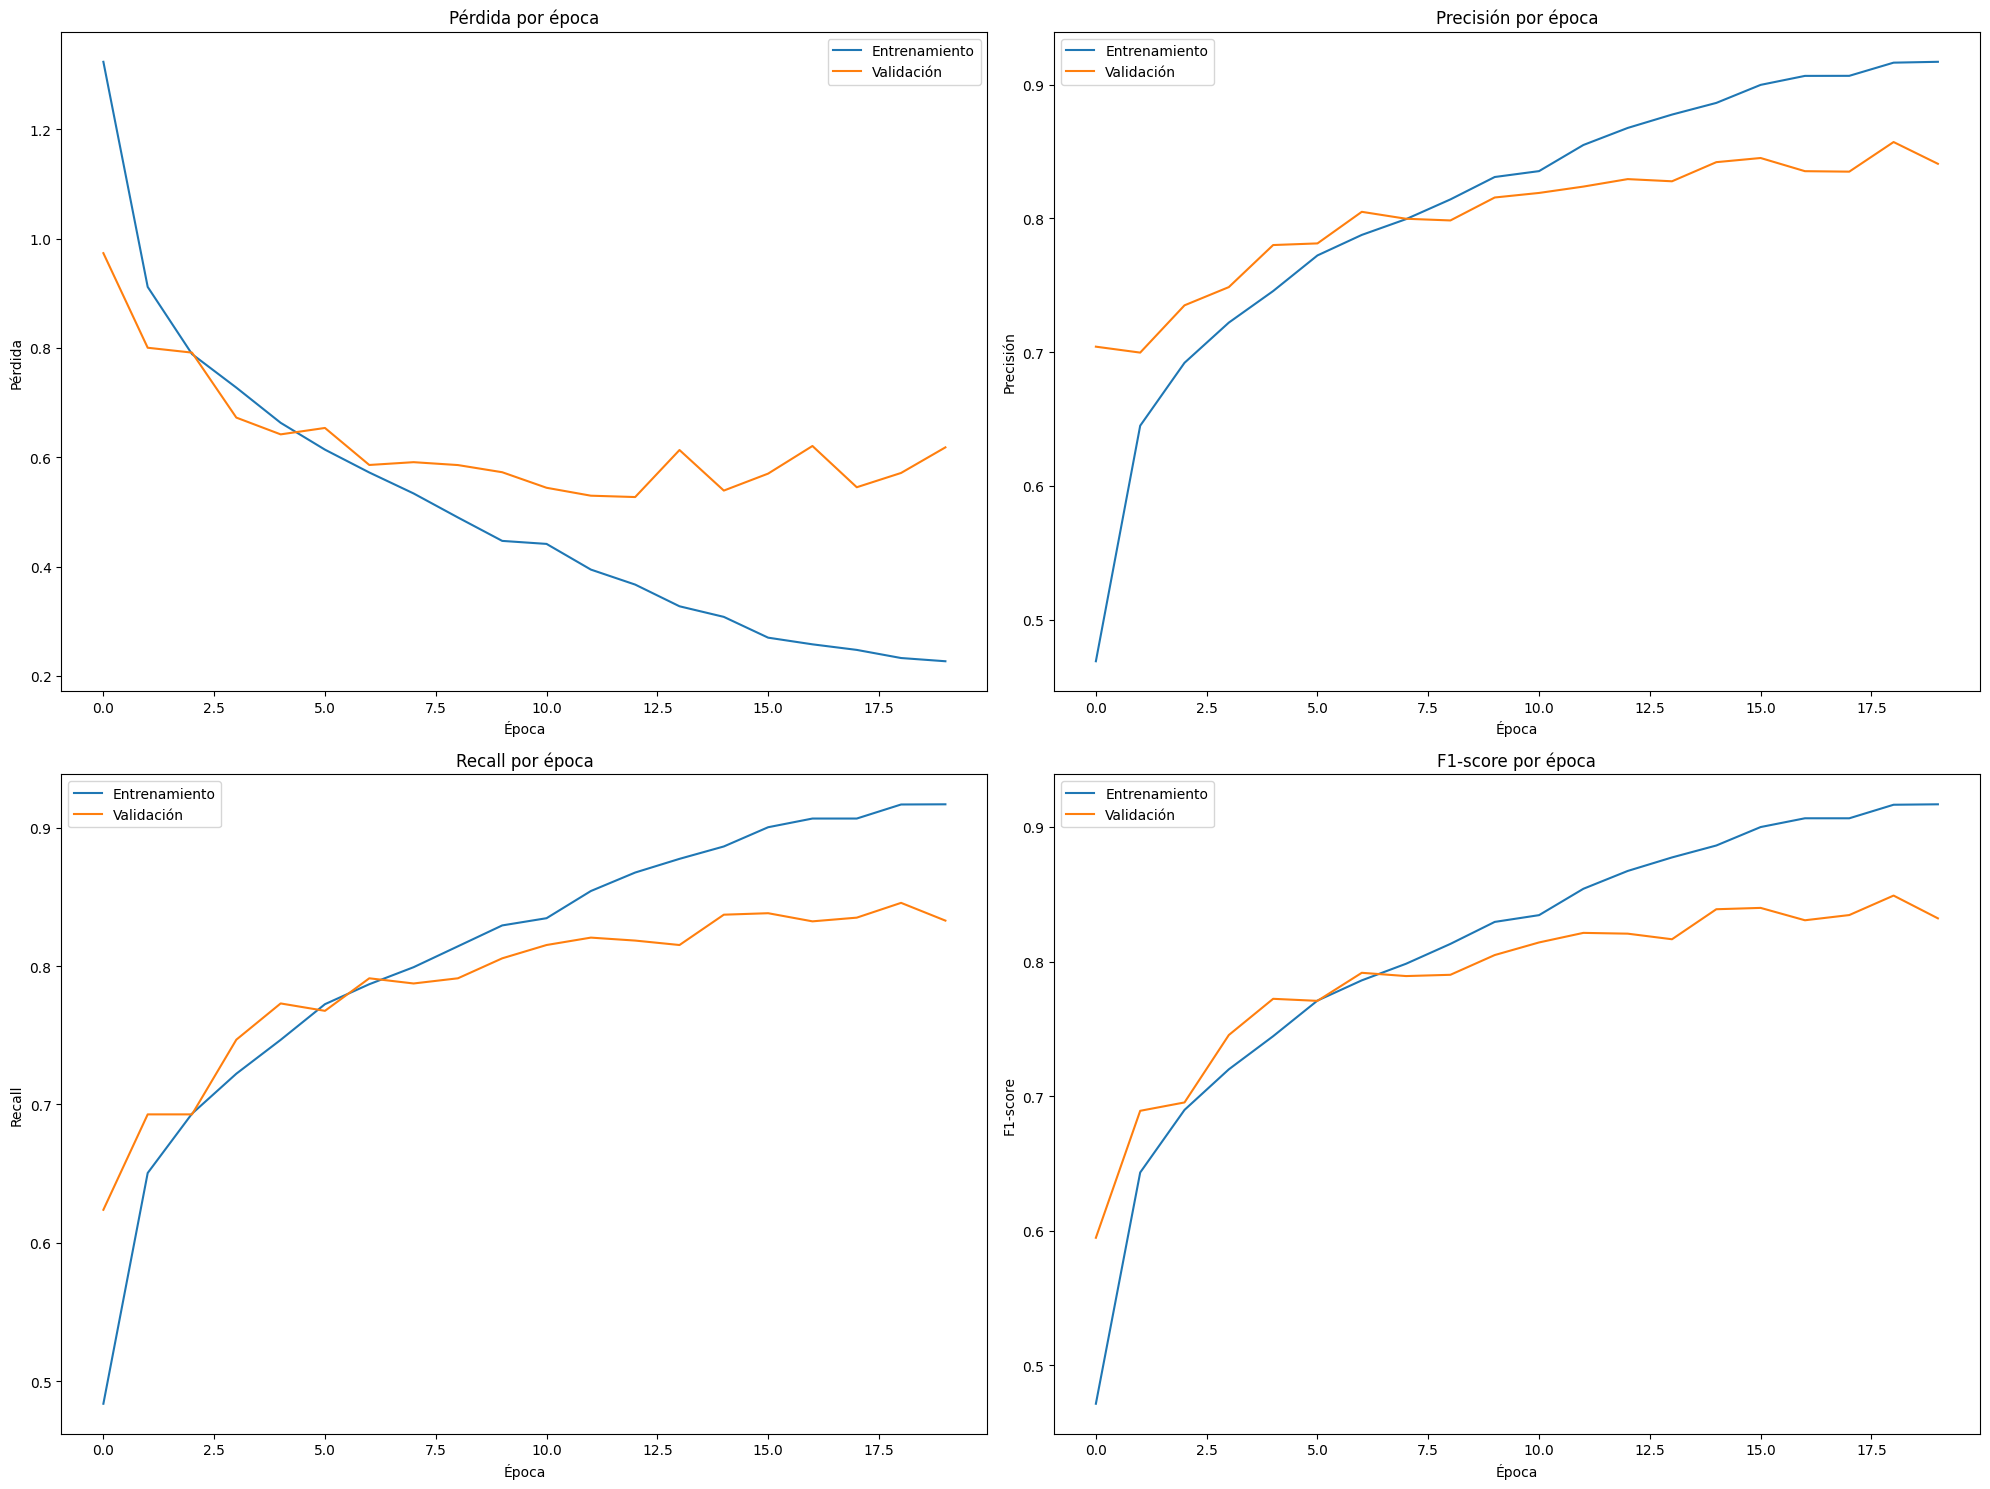

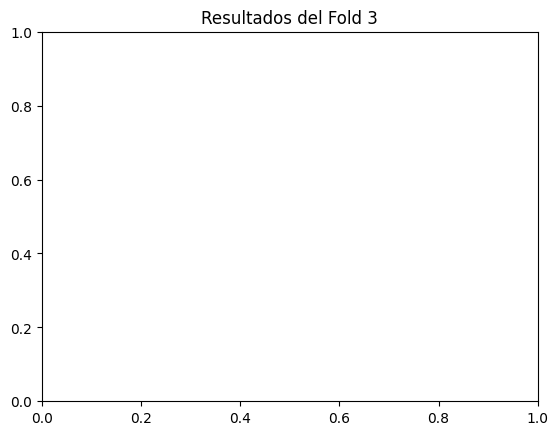

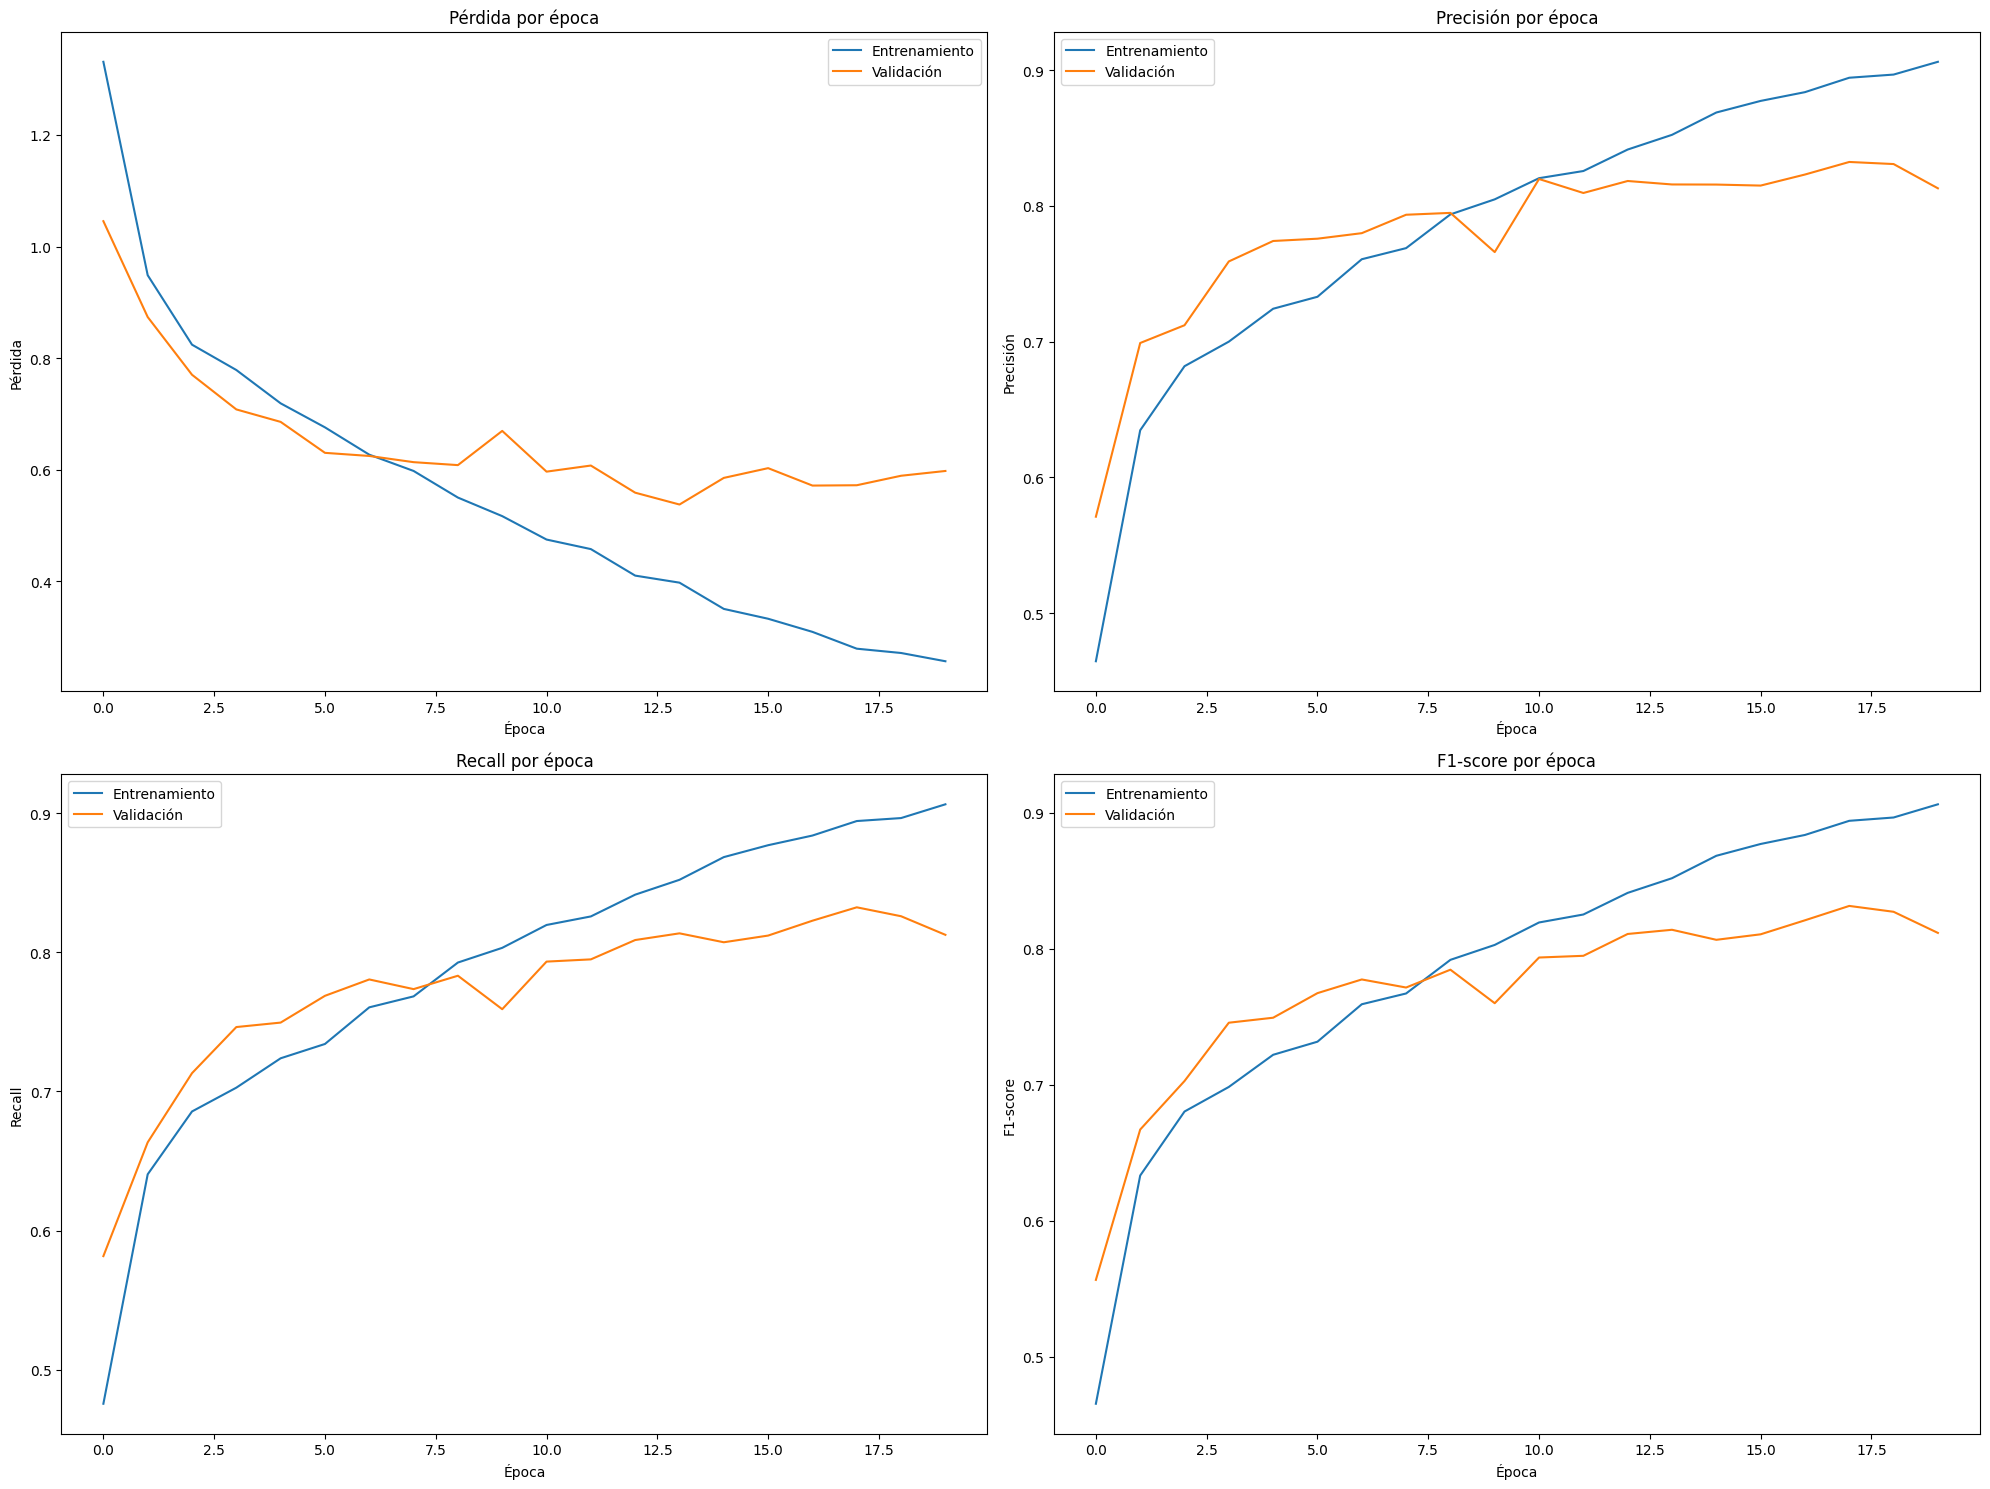

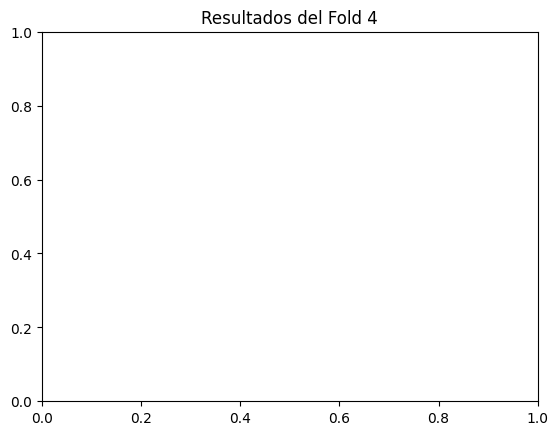

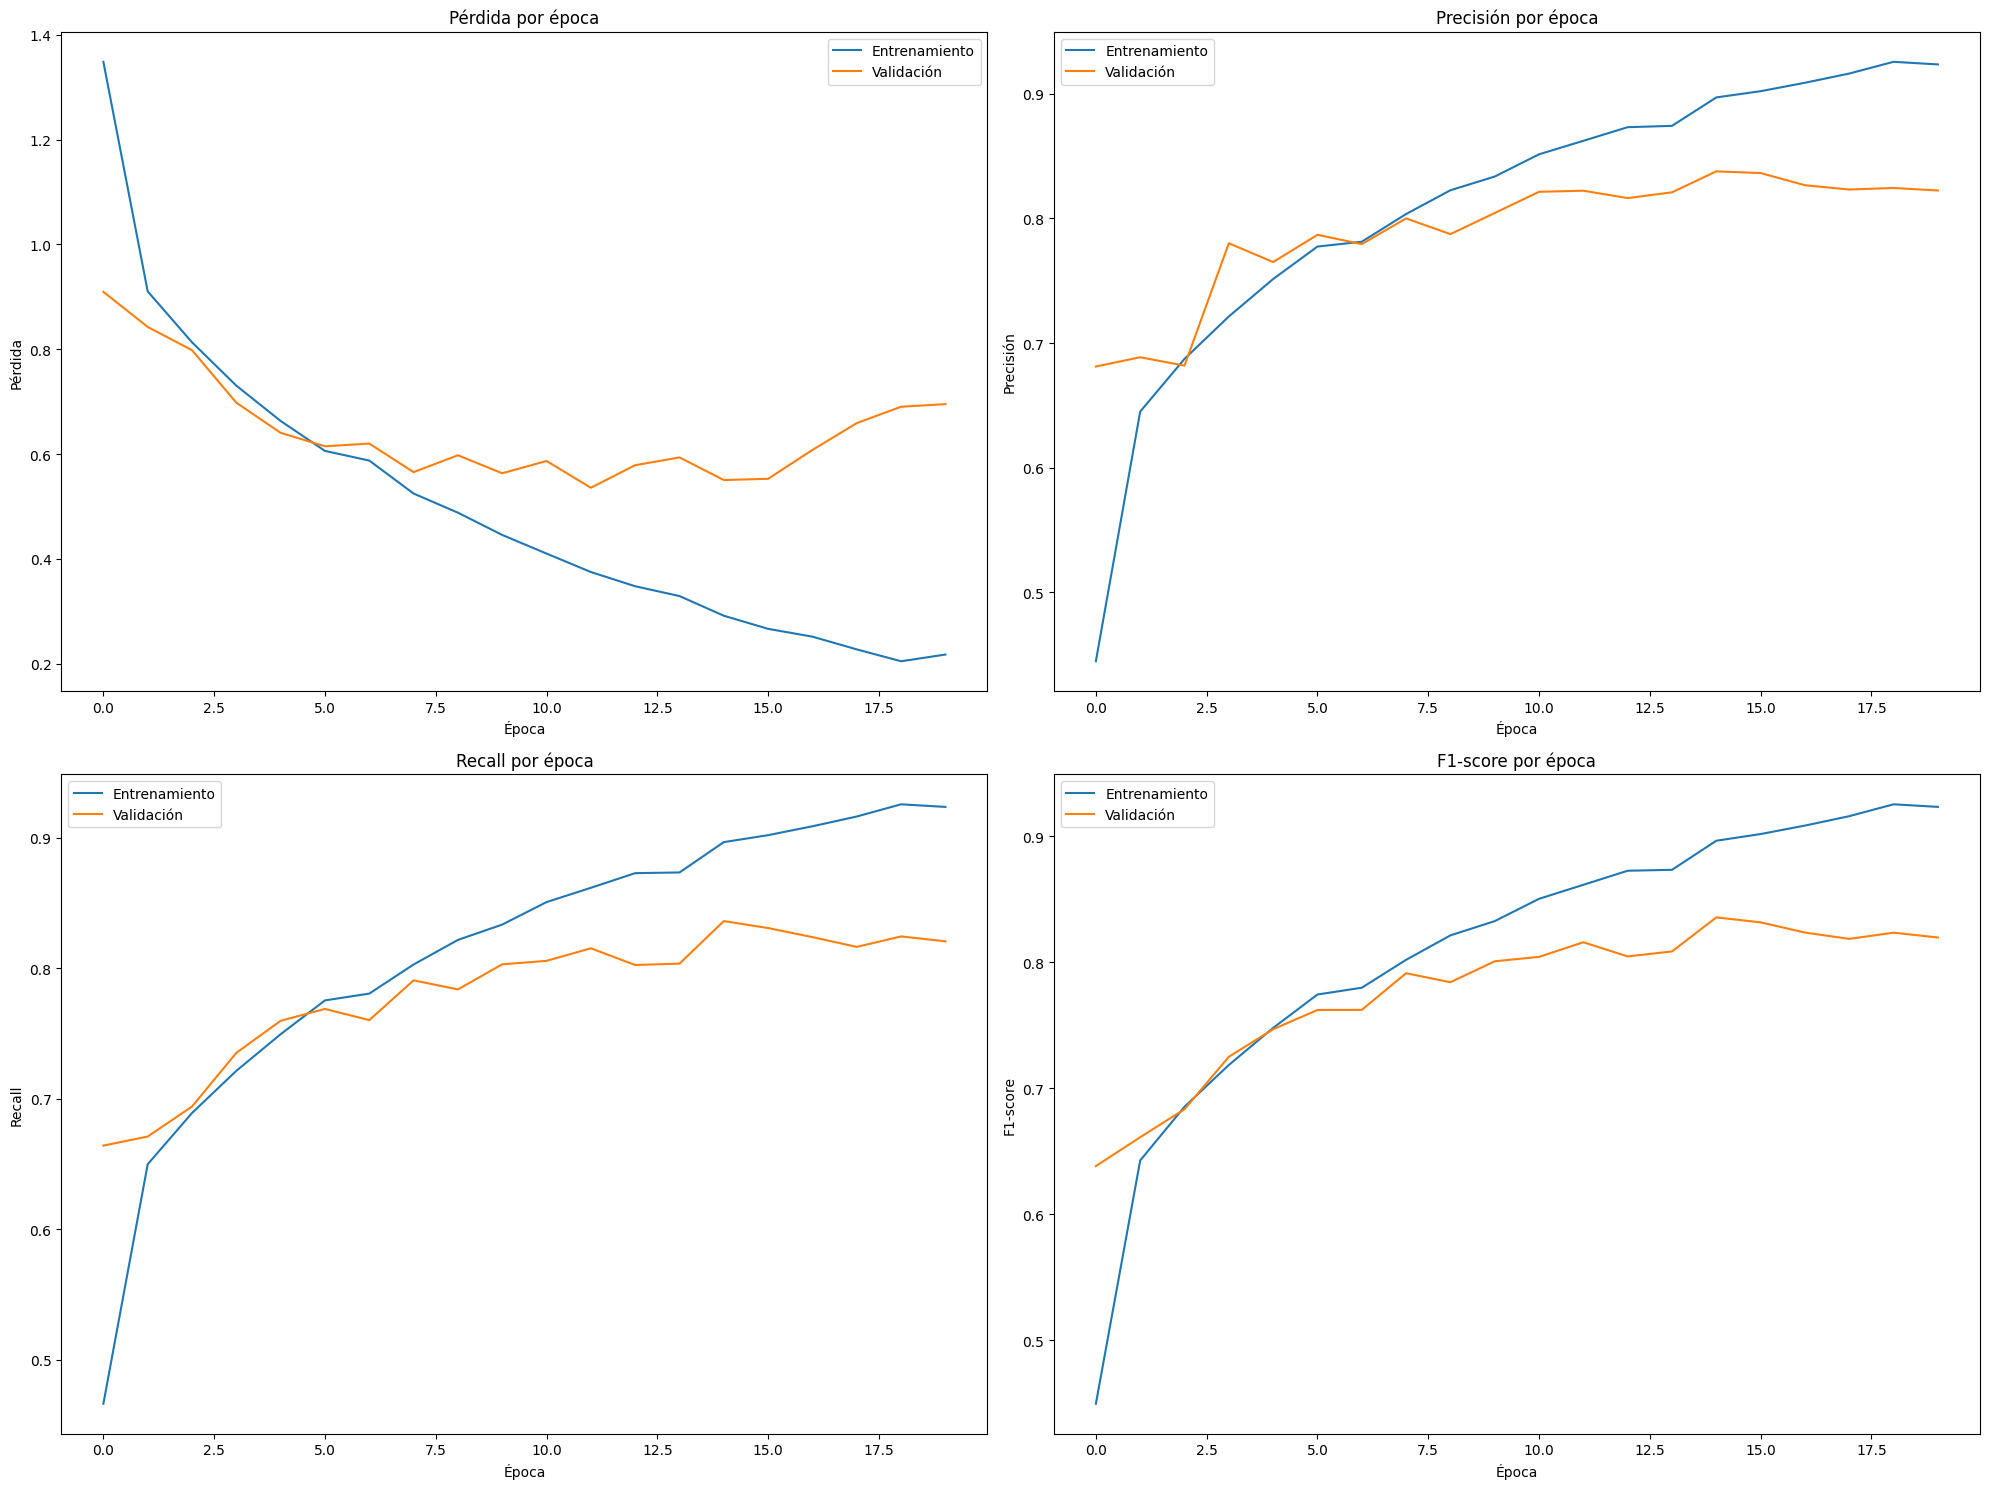

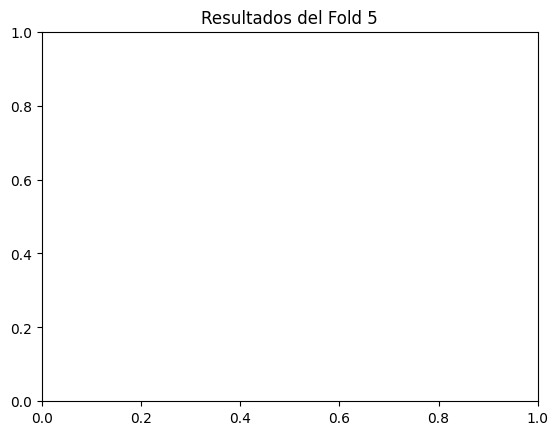

In [14]:
# 3. Visualizar resultados de la validación cruzada
for i, results in enumerate(fold_results):
    train_losses, val_losses, train_metrics, val_metrics = results
    plot_training_history(train_losses, val_losses, train_metrics, val_metrics)
    plt.title(f'Resultados del Fold {i+1}')
    plt.show()

In [15]:
# Entrenar el modelo final con todos los datos de entrenamiento + validación
final_model = create_model(num_classes)
final_trainloader = DataLoader(train_val_dataset, batch_size=32, shuffle=True)
final_train_losses, _, final_train_metrics, _ = train_model(final_model, final_trainloader, final_trainloader, epochs, lr)

Época 1/20
Train Loss: 1.4171, Val Loss: 0.9679
Train Metrics: Precision=0.4275, Recall=0.4410, F1=0.4317
Val Metrics: Precision=0.6297, Recall=0.6138, F1=0.5847
Época 2/20
Train Loss: 0.9428, Val Loss: 0.8614
Train Metrics: Precision=0.6248, Recall=0.6335, F1=0.6248
Val Metrics: Precision=0.7133, Recall=0.6583, F1=0.6585
Época 3/20
Train Loss: 0.8253, Val Loss: 0.6726
Train Metrics: Precision=0.6866, Recall=0.6885, F1=0.6849
Val Metrics: Precision=0.7686, Recall=0.7544, F1=0.7571
Época 4/20
Train Loss: 0.7445, Val Loss: 0.5923
Train Metrics: Precision=0.7107, Recall=0.7120, F1=0.7095
Val Metrics: Precision=0.8019, Recall=0.7847, F1=0.7894
Época 5/20
Train Loss: 0.7024, Val Loss: 0.5393
Train Metrics: Precision=0.7365, Recall=0.7359, F1=0.7346
Val Metrics: Precision=0.8041, Recall=0.7991, F1=0.7983
Época 6/20
Train Loss: 0.6587, Val Loss: 0.5698
Train Metrics: Precision=0.7516, Recall=0.7514, F1=0.7503
Val Metrics: Precision=0.8008, Recall=0.7918, F1=0.7921
Época 7/20
Train Loss: 0.608

In [16]:
# Evaluar el modelo final en el conjunto de prueba
all_labels, all_preds, all_probs, cm, precision, recall, f1 = evaluate_model(final_model, test_loader, num_classes)


Matriz de confusión:
 [[118   1   0   0   0   0   0   0]
 [  0  88   4  24   7   2   1   1]
 [  0   3 117   4   2   1   0   0]
 [  2  17   6 110   5   1   3   0]
 [  0  10   2   7 111   6   2   0]
 [  0  11   0   3  11  88   1   0]
 [  0   3   0   0   1   3 128   2]
 [  0   0   0   1   0   0   5 128]]
Precision: 0.8556
Recall: 0.8538
F1-score: 0.8543


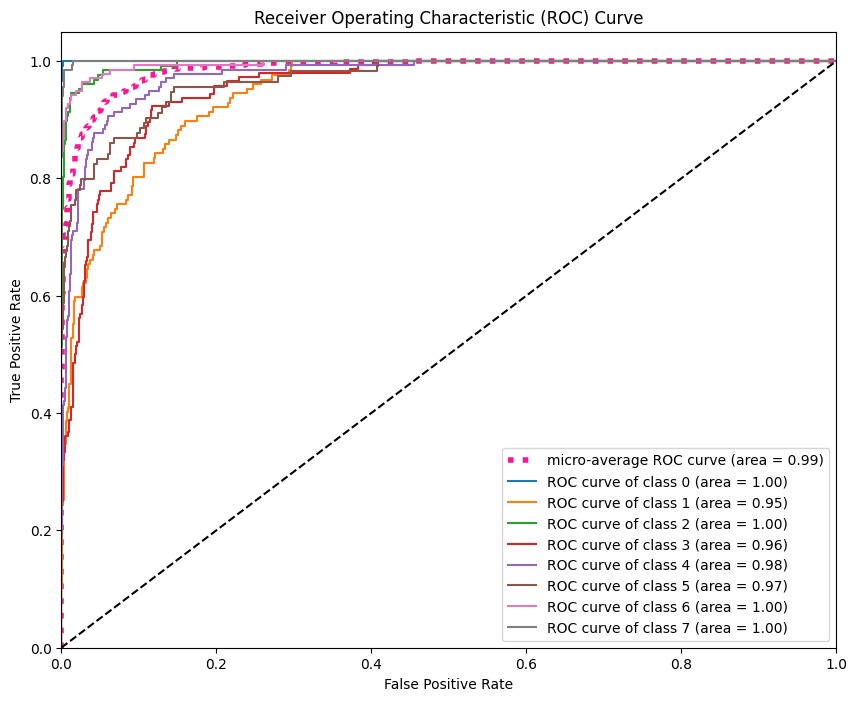

In [21]:
# Visualizar resultados finales
plot_roc_curve(all_labels, all_probs, num_classes)


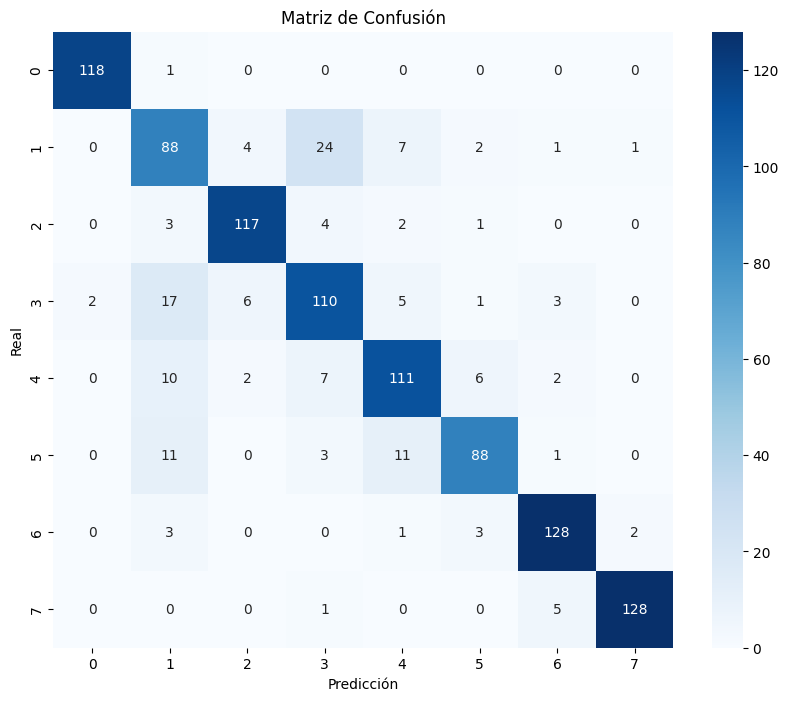

In [22]:
plot_confusion_matrix(cm)

In [18]:

#Guardar el modelo entrenado
torch.save(final_model.state_dict(), 'modelo_entrenado_final.pth')
print("Modelo guardado como 'modelo_entrenado_final.pth'")

Modelo guardado como 'modelo_entrenado_final.pth'


In [20]:
from google.colab import files
# Descargar el archivo
files.download('modelo_entrenado_final.pth')

<IPython.core.display.Javascript object>

<IPython.core.display.Javascript object>